## On the Same Wavelength: Clustering Product Demand with Dynamic Time Warping

## Problem:
The goal of this project was to improve forecasting for 1,833 high-end European kitchen products (the company that provided the data wishes to remain anonymous). Demand for this product is highly seasonal with 45-48 percent of all sales occurring in the fourth quarter of the year. All forecasting is done on a yearly basis since long lead times (120 days) provide little time to adjust to peak season market changes.

In [45]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from functions import load_data, ts_train_test_split, make_copy_df, plot_time_series
from functions import moving_average, RMSE, rename_columns, create_fb_forecast
from functions import decompose_timeseries
# functions for data import, processing, forecasting and plotting in the functions.py file

from product_segmentation_functions import identify_non_active, identify_new_product
from product_segmentation_functions import identify_intermittent_product
from product_segmentation_functions import identify_minute_demand, identify_repackage_product
from product_segmentation_functions import make_remainder_dataframe
# functions for product segmentation in segmentation_functions.py file

from statsmodels.tsa.api import ExponentialSmoothing
from fbprophet import Prophet
from sklearn.metrics import calinski_harabaz_score
from sklearn.externals import joblib

from clustering_functions import prep_dataframe_for_warping, assign_products
from clustering_functions import make_product_dataframe
# functions for clustering

from ts_cluster import ts_cluster
# this class was written by Alex Minnaar, minor modifications by me

In [ ]:
%load_ext autoreload
%autoreload 2
import autoreload

## 1. Load data

I received and Excel file with over 922,000 instances of product orders spanning the time period from 2012-04-08 to 2017-11-05. I grouped demand by product number, binned the daily data into even time periods (weekly total demand), and converted the index to datetime. I also checked some of the outliers (and received confirmation that both negative orders and extraordinary high level of orders existed).

In [51]:
data_df = load_data('data/time_series.xlsx')
data_df.head()

012  017  03008944ST-1  03008944ST-3  0300ST1550-1  0300ST15X9-1  \
EntDate                                                                        
2012-04-08    0    0             0             0             0             0   
2012-04-15    0    0             0             0             0             0   
2012-04-22    0    0             0             0             0             0   
2012-04-29    0    0             0             0             0             0   
2012-05-06    0    0             0             0             0             0   

            0300ST15X9-2  0300ST15X9-3  0300ST1605-1  0300ST1605-2   ...     \
EntDate                                                              ...      
2012-04-08             0             0             0             0   ...      
2012-04-15             0             0             0             0   ...      
2012-04-22             0             0             0             0   ...      
2012-04-29             0             0             0             0   ...      
2012-05-06             0             0             0             0   ...      

            9920-2  9920-3  9920-4  9920-5  9920-6  9920-7  9997-25  HW220D15  \
EntDate                                                                         
2012-04-08       0       0       0       0       0       0        0         0   
2012-04-15      20      19       7     166      98       0        0         0   
2012-04-22      41      15      10     207      87       0        0         0   
2012-04-29      38      44      13     101      21      10        0         0   
2012-05-06      29      47      21      75      43       0        0         0   

            HW240DIA  TRUHONE  
EntDate                        
2012-04-08         0        0  
2012-04-15         0        0  
2012-04-22         0        0  
2012-04-29         0        0  
2012-05-06         0        0  

[5 rows x 1833 columns]

## 2. Train-Test Split

Time series data cannot be evaluated using traditional cross validation methods. That leaves two options:
* Splitting the data manually using a certain point in time as the division line between 'past' observations (the training set) and 'future' values (the testing set to measure forecasts against).
* Splitting data into multiple training/testing folds using TimeSeriesSplit from the sklearn library.

Since forecasting is done on a yearly basis and my dataset only covers the time period through November 2017, I decided to split the data manually, using 5 years' worth for training, 1 year for testing, and then producing with the option of creating a third forecast for November 2017-May 2018 that the company can test against data unseen by any of my models.

In [52]:
# splitting into training and testing sets setting aside last year for testing
train_df, test_df = ts_train_test_split(data_df, 52)
# test set has been set aside until models are trained...

Observations: 292
Training Observations: 240
Testing Observations: 52


## 3. Pick Forecasting Metric and Models

### Forecasting Metric:
I selected Root Mean Squared Error (RMSE) as a forecasting metric. RMSE is a scale-dependent error but it can be used to compare different forecasting methods on a single dataset. <br>
<br>
* RMSE: $\sqrt{\frac{(A_t-F_t)^2}{n}}$ <br>

### Forecasting Methods:
I compared three methods for forecasting for seasonal demand: 
* Box-Jenkins (seasonal ARIMA), which is a 5-step process, including optimizing 7 parameters;
* Holt-Winters (Triple Exponential Smoothing), which requires adjusting 7 parameters, some of them to 3-point decimals; and
* FB Prophet, which was built to with the goal "to make it easier for experts and non-experts to make high quality forecasts that keep up with demand." Rather than requiring substantial experience in tuning parameters, "Prophet’s default settings (...) produce forecasts that are often accurate as those produced by skilled forecasters, with much less effort." (see blog post:
https://research.fb.com/prophet-forecasting-at-scale/)

That sounds great, why bother with the other methods? Let's look at item # 9920-2:

In [4]:
# make a df to store all our predictions
y_hat = make_copy_df(test_df, '9920-2')

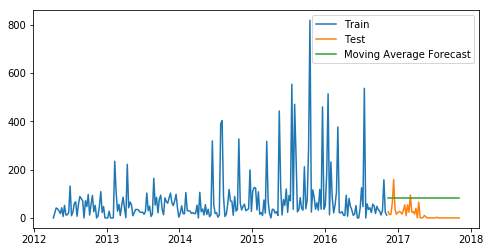

70.59469489094461

In [18]:
# baseline: Moving Average with 52
y_hat['moving_avg'] = moving_average(train_df['9920-2'], m=52)

plot_time_series(train_df, test_df, '9920-2', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'9920-2', y_hat, 'moving_avg')

Okay, 70.59, that's not great. Let's see what Prophet can do:

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


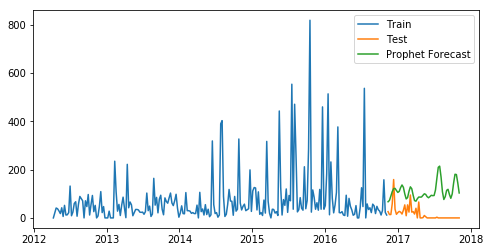

104.04466571337738

In [11]:
# FB Prophet
# make a copy of the dataframe for Prophet transformations
prophet_df = make_copy_df(train_df, '9920-2')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
rename_columns(prophet_df, '9920-2')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)

# fit
my_model.fit(prophet_df)

# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)

# plot
forecast_slice = create_fb_forecast(forecast, 240, 292)
plot_time_series(train_df, test_df, '9920-2', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '9920-2', forecast_slice, 'yhat')

104.04 is 50 percent higher than a simple averaging method! How about Holt-Winters?

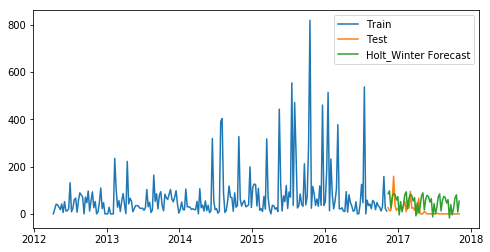

51.35384040458961

In [13]:
# Holt-Winters with additive trend and seasonality, no trend damping, seasonal periods=12
fit1 = ExponentialSmoothing(np.asarray(train_df['9920-2']), 
                            seasonal_periods=12, trend='additive', 
                            seasonal='additive').fit(smoothing_level=0.51,
                            smoothing_slope=0.015, smoothing_seasonal=0.1)

y_hat['Holt_Winter'] = fit1.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '9920-2', y_hat, 'Holt_Winter', 'Holt_Winter Forecast')

# calculate RMSE
RMSE(test_df,'9920-2', y_hat, 'Holt_Winter')

At 51.35, Holt-Winters does much better (and this is only with some manual tuning based on very simple guidelines).<br>

Given that:
* the accuracy of forecasts is highly dependent on the underlying distribution of data,
* 2 of the 3 forecasting methods require a great deal of parameter tuning, and
* there are 1,833 products to forecast altogether, <br>
it would be best to group together products that move similarly in time and can be forecasted using the same methods.

That's what k-means clustering with dynamic time warping can accomplish. However, before doing that, let's see if some of the products could be eliminated!

## 4. Segment Products

In [ ]:
# make a list of products
product_SKUs = train_df.columns.values

First I dropped products that are no longer active (defined as products that have not moved after a specified date).

In [55]:
# not active
non_active = identify_non_active(train_df, product_SKUs, 2015, 11, 4)

Then I dropped products that are new, which do not have any history to forecast.

In [56]:
# new products 
new_products = identify_new_product(train_df, product_SKUs, 2015, 11, 4)

Altogether, non active and new products accounted for 610 products. Next, I looked for products with intermittent demand (they should be forecasted using Croston's Method). Intermittent demand was defined as no demand in certain amount of weeks (here, I picked 4).

In [57]:
# intermittent demand    
intermittent_demand = identify_intermittent_product(train_df, product_SKUs, non_active, 2015, 11, 4, 4)

Interestingly, there were no products with intermittent demand. There were some products that are ordered in such small quantities, that spending a great deal of time on manually tuning their forecasting models may not be the best use of time. I set aside items that do not sell more than 30 units.

In [58]:
# products with very little demand
minute_demand = identify_minute_demand(train_df, product_SKUs, 30)

Finally, some products are ordered in large quantities (over 3,000 units) and then repackaged into sets.

In [59]:
# repackaged products
repackage_product = identify_repackage_product(train_df, product_SKUs, 3000)

After dropping the above categories, I was left with 878 products, all ready for clustering with dynamic time warping!

In [60]:
# create leftover dataset for dynamic time warping
products = make_remainder_dataframe(train_df, product_SKUs, non_active, new_products, minute_demand, repackage_product)

## 5. Cluster Products

To cluster together similar time series, I used k-means clustering with dynamic time warping. Dynamic time warping is a measure that finds the best alignment between two time series. (For more on the method, see Alex Minnaar's excellent blog post: http://alexminnaar.com/time-series-classification-and-clustering-with-python.html)

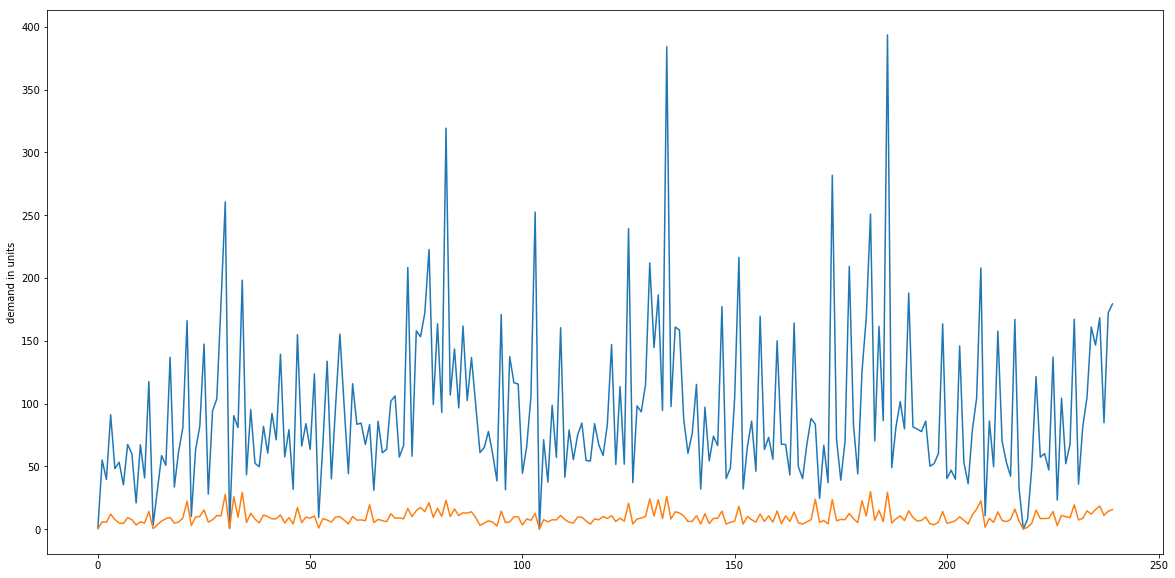

In [62]:
# prepare products df for timewarping
data_arr = prep_dataframe_for_warping(products)

# k-means clustering with k=2
cl_obj=ts_cluster(2)
cl_obj.k_means_clust(data_arr,10,4, progress=False)

# plot the two product types
cl_obj.plot_centroids()

The resulting plot shows two distinct time series types: one with modest fluctations and one with dramatic changes in demand.

In [ ]:
# pickle this model
joblib.dump(cl_obj, "my_model_k2.pkl")

## 6. Evaluate Clusters

Now I have 6 groups of products: not active, new products, minute demand, products for repackaging, and the two clusters (modest fluctuations and seasonal swings). To make sure these groups are truly insightful, I compared the above segmentation method (manual segmentation combined with clustering) to clustering only.

The combination method produces 6 segments and a Calinski-Harabasz index of 114.91. (This index shows how different clusters are from one another. The bigger the number, the sharper the differences between segments.)

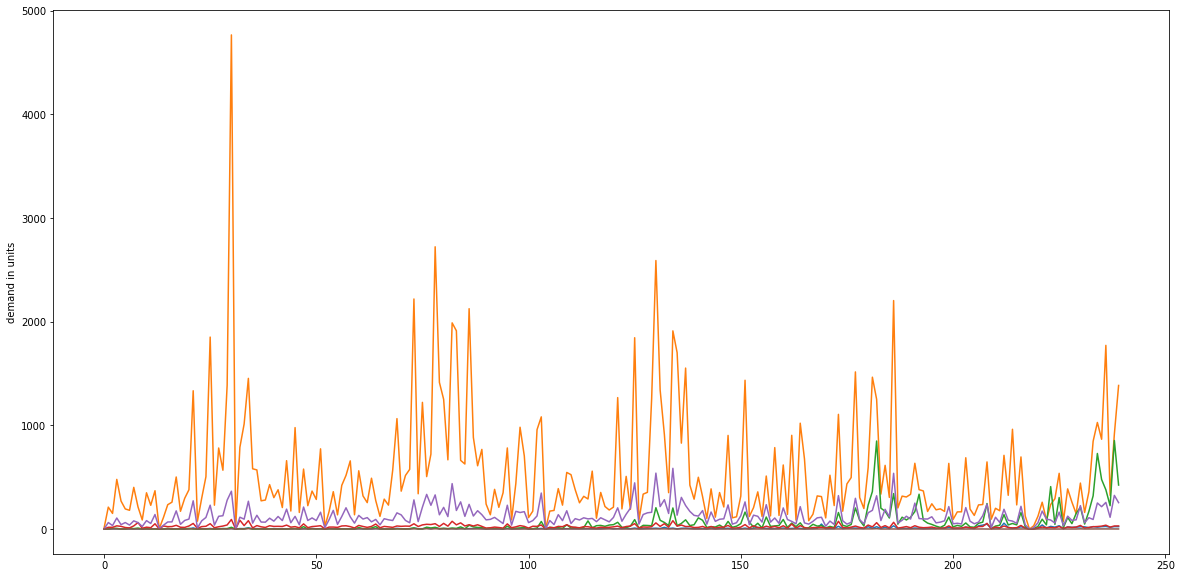

In [24]:
# prepare products df for timewarping
data_arr = prep_dataframe_for_warping(train_df)

# k-means clustering on full dataset with k=6
cl_obj=ts_cluster(6)
cl_obj.k_means_clust(data_arr,10,4, progress=False)

# plot the six product types
cl_obj.plot_centroids()

In [ ]:
products=train_df

# save dictionary containing assignments
assigned_data = cl_obj.get_assignments()

# assign products to clusters
product_type0 = assign_products(products.T, assigned_data, 0)
product_type1 = assign_products(products.T, assigned_data, 1)
product_type2 = assign_products(products.T, assigned_data, 2)
product_type3 = assign_products(products.T, assigned_data, 3)
product_type4 = assign_products(products.T, assigned_data, 4)
product_type5 = assign_products(products.T, assigned_data, 5)

# Make a data frame of products
type0_df = make_product_dataframe(products, product_type0, 'type 0')
type1_df = make_product_dataframe(products, product_type1, 'type 1')
type2_df = make_product_dataframe(products, product_type2, 'type 2')
type3_df = make_product_dataframe(products, product_type3, 'type 3')
type4_df = make_product_dataframe(products, product_type4, 'type 4')
type5_df = make_product_dataframe(products, product_type5, 'type 5')

df_new = pd.concat([type0_df, type1_df, type2_df, type3_df, type4_df, type5_df])

In [22]:
# get Caliniski-Harabasz score
X = df_new.iloc[:, df_new.columns != 'label']
y = df_new.label

CH_score_ns_k6 = calinski_harabaz_score(X, y)
CH_score_ns_k6

181.6782369681932

By contrast, creating 6 segments using clustering produces a much higher Calinski-Harabasz index of 181.67. (In other words, the k-means algorithm finds more meaningful patterns in the data than manual segmentation.)

In [23]:
# pickle this model
joblib.dump(cl_obj, "my_model_ns_k6.pkl")

['my_model_ns_k6.pkl']

## 7. Next Steps

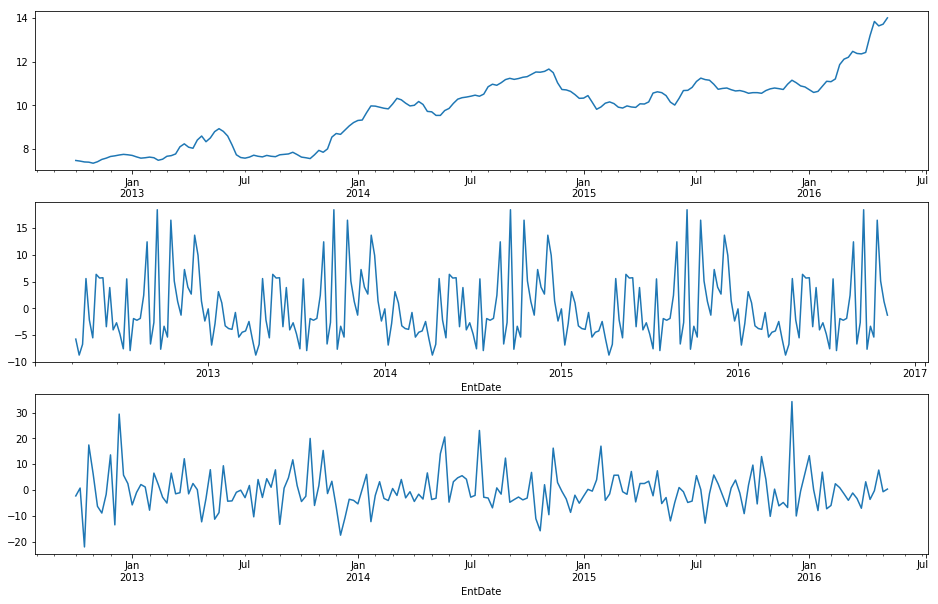

In [63]:
# look at the trend and season components of the timeseries from an item from Product Group 0
decompose_timeseries(train_df['8620'], 'additive')

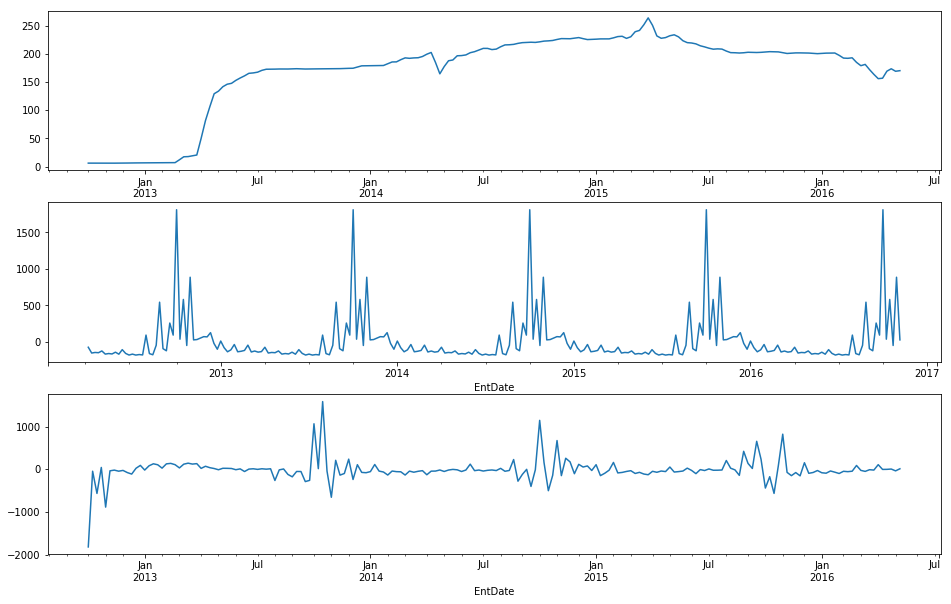

In [64]:
# look at the trend and season components of the timeseries from an item from Product Group 4
decompose_timeseries(train_df['9740-1'], 'additive')

Neverthless, some product groups and orders may be flagged for special treatment based on business considerations. As next step, we now have a solid m

the "best" number of clusters are dependent on a number of business considerations. 

The drawback to k-means clustering is that there is no standard method to find the "best" number of clusters. Clusters are usually selected based on managerial considerations - how many 

## Resources:

### 2. Train-Test Split: 
For more on time series data and cross-validation, see 
[this blog post] (https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)
this blog post: https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

### 3. Forecasting Models:
* Time Series (ETS) tutorial: https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
* More on exponential smoothing: https://www.otexts.org/fpp/7 and https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/
* Time Series (ARMA) overview: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#LinearModels
* ARIMA tutorial: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
* ARIMA with pyramid library: https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

### 5. Clustering with Dynamic Time Warping:
* Excellent blog post (with link to code in GitHub): http://alexminnaar.com/time-series-classification-and-clustering-with-python.html
* Several resources in comments below: https://stats.stackexchange.com/questions/131281/dynamic-time-warping-clustering?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa